<a href="https://colab.research.google.com/github/2000siddharth/TaxiFarePrediction/blob/master/linearRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [3]:
df = pd.read_csv('train_file.csv', index_col=0)

In [4]:
df.shape

(97908, 14)

In [5]:
df = df.drop('color', axis=1)

In [9]:
df.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,weekday,fare-bin,haversine
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,2009,6,15,17,0,"(0.0, 5.0]",1.031896
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,2010,1,5,16,1,"(15.0, 20.0]",8.459418
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,2011,8,18,0,3,"(5.0, 10.0]",1.391052
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,2012,4,21,4,5,"(5.0, 10.0]",2.802346
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,2010,3,9,7,1,"(5.0, 10.0]",2.001353


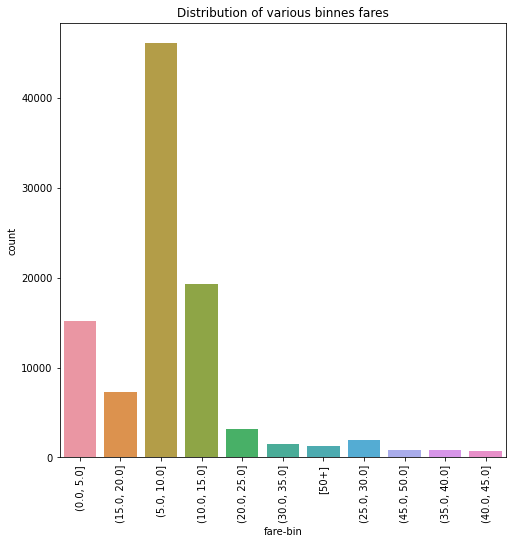

In [19]:
plt.figure(figsize=(8,8))
sns.countplot(df['fare-bin'])
plt.xticks(rotation=90)
plt.title('Distribution of various binnes fares')
plt.show()

In [20]:
# For regression we won't be using the feature - 'fare-bin' since it is representative of the target value.
# We shall also minimise the chances of using highly correlated features as they might bring interpretability issues in the model.

In [6]:
# Absolute difference in latitude and longitude
df['abs_lat_diff'] = (df['dropoff_latitude'] - df['pickup_latitude']).abs()
df['abs_lon_diff'] = (df['dropoff_longitude'] - df['pickup_longitude']).abs()

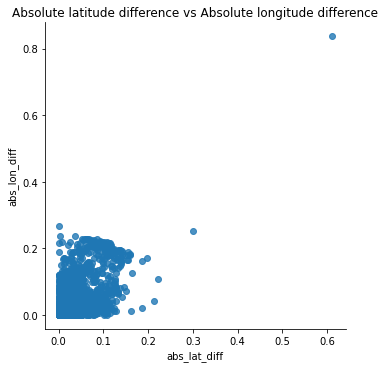

In [23]:
sns.lmplot('abs_lat_diff', 'abs_lon_diff', fit_reg = False,
           data = df.sample(10000, random_state=10));
plt.title('Absolute latitude difference vs Absolute longitude difference');

/usr/local/lib/python3.6/dist-packages/seaborn/regression.py:573: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


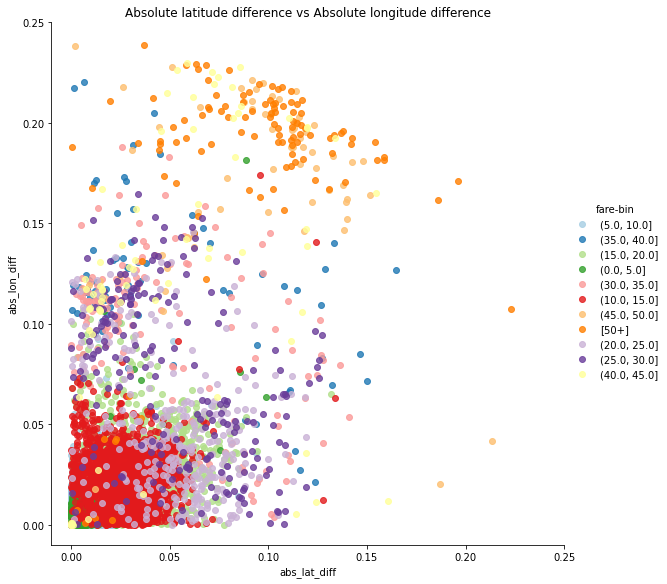

In [28]:
palette = sns.color_palette('Paired', 11)
sns.lmplot('abs_lat_diff', 'abs_lon_diff', hue = 'fare-bin', size = 8, palette = palette,
           fit_reg = False, data = df.sample(10000, random_state=10));

plt.xlim((-0.01, .25)); plt.ylim((-0.01, .25))
plt.title('Absolute latitude difference vs Absolute longitude difference');

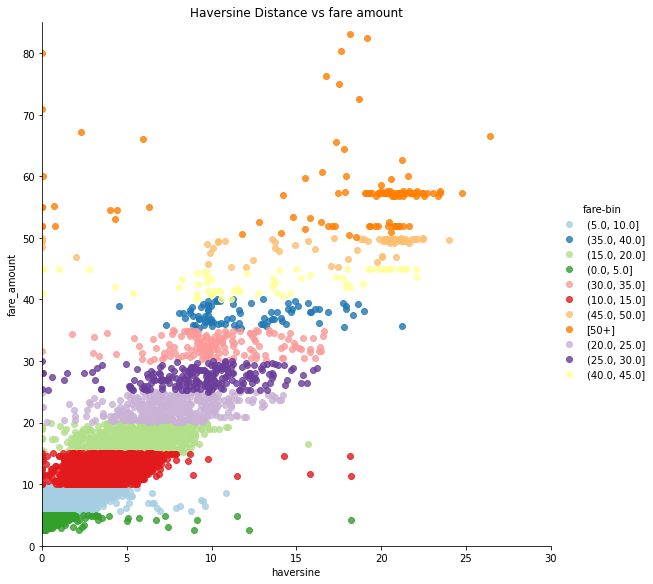

In [36]:
palette = sns.color_palette('Paired', 11)
sns.lmplot('haversine', 'fare_amount', hue = 'fare-bin', height = 8, palette = palette,
           fit_reg = False, data = df.sample(10000, random_state=10));

plt.xlim((-0.01,30 )); plt.ylim((-0.01, 85))
plt.title('Haversine Distance vs fare amount');

In [37]:
# From the above graph it is clear that we have a linear relationship between 'Fare' and 'Haversine distance'
# Using the features gathered so far we shall first with a simple regression model without any pre-processing

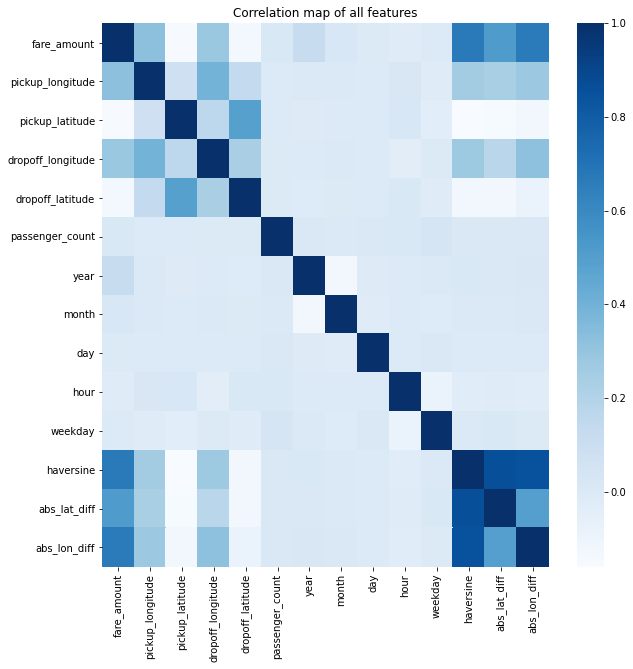

In [41]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), cmap='Blues')
plt.title('Correlation map of all features')
plt.show()

In [ ]:
# We shall use 'haversine', 'abs_lon_diff', 'abs_lat_diff', 

In [75]:
df.columns

Index(['fare_amount', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year',
       'month', 'day', 'hour', 'weekday', 'fare-bin', 'haversine',
       'abs_lat_diff', 'abs_lon_diff', 'haversine_sq', 'log_year', 'log_dist',
       'log_dist2'],
      dtype='object')

In [76]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(df, np.array(df['fare_amount']), 
                                                      stratify = df['fare-bin'], 
                                                      random_state = 10)

In [81]:
lr = LinearRegression()

lr.fit(X_train[['haversine', 'abs_lat_diff', 'abs_lon_diff', 'log_dist']], y_train)
print('Training Done')
print('Co-efficients are: ')
print('abs_lat_diff coef: ', round(lr.coef_[1], 4), 
      '\tabs_lon_diff coef:', round(lr.coef_[2], 4),
      '\thaversine:', round(lr.coef_[0], 4),
      '\thaversine log:', round(lr.coef_[3], 4)
      )

y_pred = lr.predict(X_test[['haversine', 'abs_lat_diff', 'abs_lon_diff', 'log_dist']])

Training Done
Co-efficients are: 
abs_lat_diff coef:  118.0793 	abs_lon_diff coef: 148.5757 	haversine: -0.7073 	haversine log: 4.6615


In [8]:
def scorer(y_true, y_pred, p):
  print('Root-Mean-Squared Error is: ', np.sqrt(mean_squared_error(y_true, y_pred)))
  print('Mean Absolute Error is: ', (mean_absolute_error(y_true, y_pred)))
  R2 = r2_score(y_true, y_pred)
  print('R2 error is : ', R2)
  adj_r2 = (1 - (1-R2)*(len(y_true)-1)/(len(y_true)-p-1))
  print('Adjusted R2 score is: ', adj_r2)

In [82]:
scorer(y_test, y_pred, 3)

Root-Mean-Squared Error is:  6.440767781250677
Mean Absolute Error is:  3.3226349913477753
R2 error is :  0.5534344489947494
Adjusted R2 score is:  0.5533797071709837


In [ ]:
# 1-(1-R2)*(n-1)/(n-p-1)

In [83]:
# Now let us scale the data so that all some irrelevant features don't get high weights
# I will use the Standard Scaler

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train[['haversine', 'abs_lat_diff', 'abs_lon_diff', 'log_dist']])
X_train_scaled = scaler.transform(X_train[['haversine', 'abs_lat_diff', 'abs_lon_diff', 'log_dist']])
X_test_scaled = scaler.transform(X_test[['haversine', 'abs_lat_diff', 'abs_lon_diff', 'log_dist']])
print('Scaling Done..')

Scaling Done..


In [84]:
X_train_scaled

array([[ 2.45334019,  3.36627896,  1.16797957,  1.8178663 ],
       [-0.32118302, -0.20822392, -0.32821601, -0.12089329],
       [-0.40926548, -0.28522606, -0.49098621, -0.35200319],
       ...,
       [ 0.26684632,  0.55903542, -0.0311982 ,  0.72339443],
       [-0.34518699, -0.25942394, -0.30458503, -0.17845668],
       [-0.34606765, -0.66622836, -0.05683782, -0.18063711]])

In [85]:
lr = LinearRegression()

lr.fit(X_train_scaled, y_train)
print('Training Done')
print('Co-efficients are: ')
print('abs_lat_diff coef: ', round(lr.coef_[1], 4), 
      '\tabs_lon_diff coef:', round(lr.coef_[2], 4),
      '\thaversine:', round(lr.coef_[0], 4),
      '\thaversine log:', round(lr.coef_[3], 4)
      )
y_pred = lr.predict(X_test_scaled)

Training Done
Co-efficients are: 
abs_lat_diff coef:  3.5055 	abs_lon_diff coef: 6.2873 	haversine: -3.3051 	haversine log: 2.1537


In [86]:
scorer(y_test, y_pred, 3)

Root-Mean-Squared Error is:  6.440767781250687
Mean Absolute Error is:  3.3226349913478024
R2 error is :  0.5534344489947478
Adjusted R2 score is:  0.5533797071709823


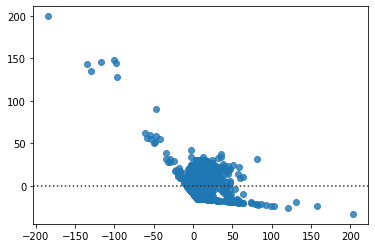

In [87]:
# Finding the residuals
residuals = y_test - y_pred
sns.residplot(residuals, y_pred)

From this residual plot we can understand that there is some non-linearity in the data, to deal with this we shall make some non-linear transformation of our dataset.

In [88]:
X_train['haversine_sq'] = np.power(X_train['haversine'], 2)
X_test['haversine_sq'] = np.power(X_test['haversine'], 2)

scaler.fit(X_train[['haversine_sq', 'abs_lat_diff', 'abs_lon_diff', 'log_dist']])
X_train_scaled = scaler.transform(X_train[['haversine_sq', 'abs_lat_diff', 'abs_lon_diff','log_dist']])
X_test_scaled = scaler.transform(X_test[['haversine_sq', 'abs_lat_diff', 'abs_lon_diff', 'log_dist']])
print('Scaling Done..')

lr = LinearRegression()

lr.fit(X_train_scaled, y_train)
print('Training Done')
print('Co-efficients are: ')
print('abs_lat_diff coef: ', round(lr.coef_[1], 4), 
      '\t abs_lon_diff coef:', round(lr.coef_[2], 4),
      '\t haversine_sq:', round(lr.coef_[0], 4))

y_pred = lr.predict(X_test_scaled)

Scaling Done..
Training Done
Co-efficients are: 
abs_lat_diff coef:  3.7705 	 abs_lon_diff coef: 7.1356 	 haversine_sq: -4.9152


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [89]:
scorer(y_test, y_pred, 3)

Root-Mean-Squared Error is:  5.726150344565015
Mean Absolute Error is:  2.765581374365366
R2 error is :  0.6470319233200871
Adjusted R2 score is:  0.6469886550558759


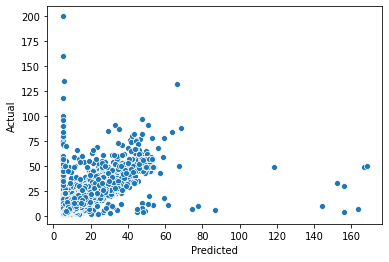

In [90]:
sns.scatterplot(y=y_test, x=y_pred)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

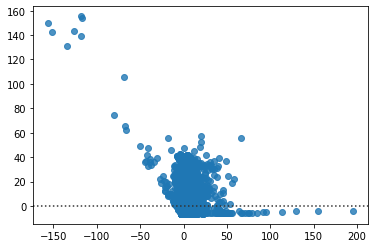

In [91]:
residuals = y_test - y_pred
sns.residplot(residuals, y_pred)

We see that after including the polynomial term our error decreased and the variance explained (R2 score) by the model also increased significantly. 
This model has high interpretability and can be understood easily

### We shall now use all the features of our dataset and see whether we are able to improve our predictions or not.

## 1. Simple Multinomial Regression model without penalty

In [92]:
# Now lets include all features and see if there is any significant change in the performance
X_train.columns

Index(['fare_amount', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year',
       'month', 'day', 'hour', 'weekday', 'fare-bin', 'haversine',
       'abs_lat_diff', 'abs_lon_diff', 'haversine_sq', 'log_year', 'log_dist',
       'log_dist2'],
      dtype='object')

In [93]:
features = ['passenger_count', 'year', 'day', 'log_year', 'log_dist',
       'month', 'hour', 'weekday', 'haversine',
       'abs_lat_diff', 'abs_lon_diff']

scaler = StandardScaler()
scaler.fit(X_train[features])
X_train_scaled = scaler.transform(X_train[features])
X_test_scaled = scaler.transform(X_test[features])
print('Scaling Done..')

lr = LinearRegression()

lr.fit(X_train_scaled, y_train)
print('Training Done')
# print('Co-efficients are: ')
# print('abs_lat_diff coef: ', round(lr.coef_[1], 4), 
#       '\tabs_lon_diff coef:', round(lr.coef_[2], 4),
#       '\thaversine:', round(lr.coef_[0], 4))
y_pred = lr.predict(X_test_scaled)

scorer(y_test, y_pred, len(features))

Scaling Done..
Training Done
Root-Mean-Squared Error is:  6.356745658762927
Mean Absolute Error is:  3.223707611036039
R2 error is :  0.5650096669612308
Adjusted R2 score is:  0.5648140857773589


In [94]:
print(lr.intercept_)

11.348709808741022


In [95]:
print(lr.coef_)

[ 6.23808971e-02  4.07573001e+02  2.63566774e-03 -4.06564987e+02
  2.11704834e+00  2.96526499e-01  2.68953611e-03 -8.95435715e-02
 -3.23887805e+00  3.48687599e+00  6.23753908e+00]


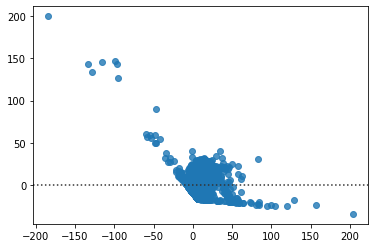

In [96]:
# Finding the residuals

residuals = y_test - y_pred
sns.residplot(residuals, y_pred)

## 2. Ridge Regression (L2 penalty)

In [20]:
from sklearn.linear_model import Ridge, Lasso

In [99]:
features = ['passenger_count', 'year', 'day', 'haversine_sq', 'log_dist',
       'month', 'hour', 'weekday',
       'abs_lat_diff', 'abs_lon_diff']

scaler = StandardScaler()
scaler.fit(X_train[features])
X_train_scaled = scaler.transform(X_train[features])
X_test_scaled = scaler.transform(X_test[features])
print('Scaling Done..')

ridge = Ridge()

ridge.fit(X_train_scaled, y_train)
print('Training Done')
# print('Co-efficients are: ')
# print('abs_lat_diff coef: ', round(ridge.coef_[1], 4), 
#       '\tabs_lon_diff coef:', round(ridge.coef_[2], 4),
#       '\thaversine:', round(ridge.coef_[0], 4))
y_pred = ridge.predict(X_test_scaled)

scorer(y_test, y_pred, len(features))

Scaling Done..
Training Done
Root-Mean-Squared Error is:  5.636171990223666
Mean Absolute Error is:  2.6652856485913556
R2 error is :  0.6580375578460118
Adjusted R2 score is:  0.6578977873718215


In [28]:
ridge.coef_

array([ 0.05248758,  1.01708485, -0.01666219,  0.27052699,  0.06611326,
       -0.07170192, -5.52480239,  8.73031123, -1.00922236,  2.32693417])

Feature: 0, Score: 0.05467
Feature: 1, Score: 1.01351
Feature: 2, Score: -0.01747
Feature: 3, Score: -4.91699
Feature: 4, Score: -0.02848
Feature: 5, Score: 0.26522
Feature: 6, Score: 0.05438
Feature: 7, Score: -0.07790
Feature: 8, Score: 3.78877
Feature: 9, Score: 7.12789


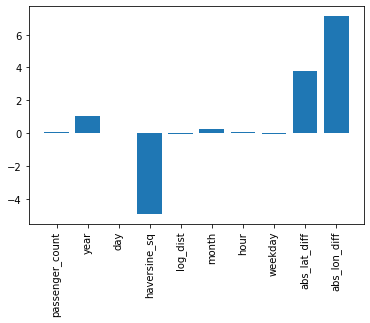

In [100]:
# get importance
importance = ridge.coef_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in features], importance)
plt.xticks(rotation=90)
plt.show()

In [35]:
min(y_pred)

2.6131170383932325

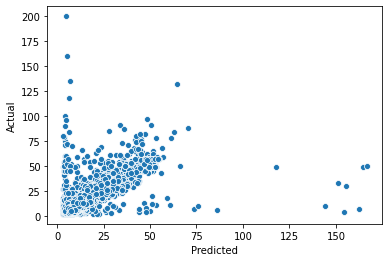

In [101]:
sns.scatterplot(y=y_test, x=y_pred)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

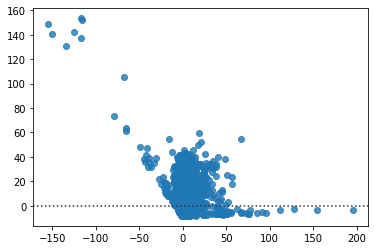

In [102]:
# Finding the residuals

residuals = y_test - y_pred
sns.residplot(residuals, y_pred)

This plot for residuals seems much better than the other plots we have made for the other models.

In [110]:
sub = pd.DataFrame({'key': X_test.index, 'fare_amount': y_pred})
sub.to_csv('sub_lr_simple.csv', index = False)

In [111]:
sub.head()

,key,fare_amount
0,90269,9.054187
1,45978,6.299205
2,60721,4.364260
3,60759,13.637336
4,68410,16.098199


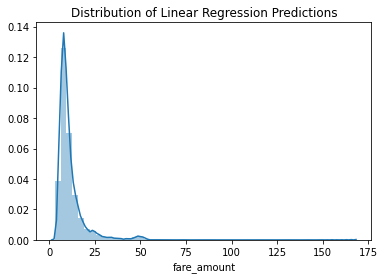

In [112]:
sns.distplot(sub['fare_amount'])
plt.title('Distribution of Linear Regression Predictions');

In [114]:
X_test.loc[sub[sub['fare_amount'] > 100]['key']]

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,weekday,fare-bin,haversine,abs_lat_diff,abs_lon_diff,haversine_sq,log_year,log_dist,log_dist2
5663,49.15,-73.137393,41.366138,-74.000940,40.731723,1,2009,2,25,7,2,"(45.0, 50.0]",101.205694,0.634415,0.863547,10242.592559,3.302980,2.005248,6.661289
7401,4.50,-73.900571,40.764047,-73.137393,41.366138,1,2009,7,16,9,3,"(0.0, 5.0]",92.707597,0.602091,0.763178,8594.698450,3.302980,1.967162,6.534771
29007,50.00,-73.137393,41.366138,-74.011292,40.702179,1,2009,3,24,11,1,"(45.0, 50.0]",104.149271,0.663959,0.873899,10847.070647,3.302980,2.017698,6.702647
73775,10.10,-73.947407,40.706902,-73.041317,39.296307,1,2010,11,4,22,3,"(10.0, 15.0]",175.000173,1.410595,0.906090,30625.060681,3.303196,2.243063,7.451295
47520,49.80,-73.870198,40.731632,-74.302143,41.349023,1,2011,6,13,13,0,"(45.0, 50.0]",77.707745,0.617391,0.431945,6038.493649,3.303412,1.890520,6.280172
64084,30.10,-75.416860,40.770613,-73.946788,40.771958,1,2011,4,14,17,3,"(30.0, 35.0]",123.930053,0.001345,1.470072,15358.658160,3.303412,2.093212,6.953499
9899,7.70,-73.974361,40.755168,-73.137393,41.366138,1,2009,8,12,19,2,"(5.0, 10.0]",97.777904,0.610970,0.836968,9560.518431,3.302980,1.990285,6.611584
17081,33.47,-73.137393,41.366138,-73.865796,40.770828,2,2009,8,21,13,4,"(30.0, 35.0]",90.157321,0.595310,0.728403,8128.342467,3.302980,1.955049,6.494533


In [115]:
sub[sub['fare_amount'] > 100]

,key,fare_amount
45,5663,164.813783
1849,7401,154.546068
4543,29007,166.671094
7444,73775,143.969263
10948,47520,117.983609
14334,64084,155.249469
22426,9899,162.230555
24205,17081,150.864294


In [103]:
features = ['passenger_count', 'year', 'day','pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude',
       'month', 'hour', 'weekday', 'haversine_sq',
       'abs_lat_diff', 'abs_lon_diff']

scaler = StandardScaler()
scaler.fit(X_train[features])
X_train_scaled = scaler.transform(X_train[features])
X_test_scaled = scaler.transform(X_test[features])
print('Scaling Done..')

lasso = Lasso()

lasso.fit(X_train_scaled, y_train)
print('Training Done')
# print('Co-efficients are: ')
# print('abs_lat_diff coef: ', round(lasso.coef_[1], 4), 
#       '\tabs_lon_diff coef:', round(lasso.coef_[2], 4),
#       '\thaversine:', round(lasso.coef_[0], 4))
y_pred = lasso.predict(X_test_scaled)

scorer(y_test, y_pred, len(features))

Scaling Done..
Training Done
Root-Mean-Squared Error is:  6.171902640788795
Mean Absolute Error is:  3.4022716563722453
R2 error is :  0.5899393756734501
Adjusted R2 score is:  0.5897214633930166


### So after the results of the different models we shall go with the Ridge regression model

##### To conduct further statistical tests for checking the validity of our regression we can't rely on the sklearn package, rather for proving statistical signifucance of our assumptions we shall be using the 'statsmodel' library from scipy

In [36]:
import statsmodels.formula.api as sm

In [45]:
df['haversine_sq'] = np.power(df['haversine'], 2)
df['log_year'] = np.log10(df['year'])
df['log_dist'] = np.log10(df['haversine']+0.01)
df['log_dist2'] = np.log2(df['haversine']+0.01)

In [39]:
df.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,weekday,fare-bin,haversine,abs_lat_diff,abs_lon_diff,haversine_sq,log_year,log_dist
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,2009,6,15,17,0,"(0.0, 5.0]",1.031896,0.009041,0.002701,1.064810,3.302980,0.013636
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,2010,1,5,16,1,"(15.0, 20.0]",8.459418,0.070701,0.036780,71.561753,3.303196,0.927340
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,2011,8,18,0,3,"(5.0, 10.0]",1.391052,0.010708,0.008504,1.935025,3.303412,0.143343
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,2012,4,21,4,5,"(5.0, 10.0]",2.802346,0.024949,0.004437,7.853142,3.303628,0.447522
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,2010,3,9,7,1,"(5.0, 10.0]",2.001353,0.015754,0.011440,4.005415,3.303196,0.301324


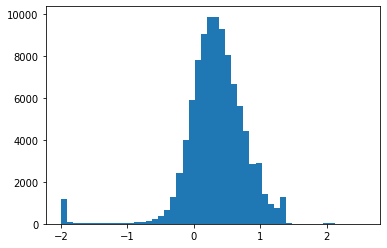

In [44]:
plt.hist(df['log_dist'], bins=50)
plt.show()

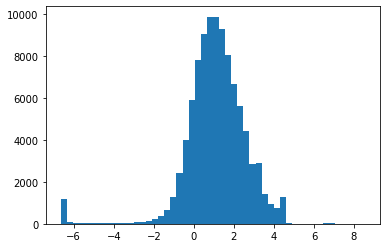

In [46]:
plt.hist(df['log_dist2'], bins=50)
plt.show()

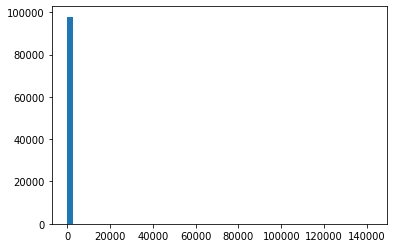

In [47]:
plt.hist(df['haversine_sq'], bins=50)
plt.show()

In [68]:
data = df[['fare_amount', 'passenger_count', 'year',
        'hour', 'weekday', 'log_dist', ,
       'abs_lat_diff', 'abs_lon_diff']]

In [69]:
formula_str = data.columns[0]+' ~ '+'+'.join(data.columns[1:])
formula_str

'fare_amount ~ passenger_count+year+hour+weekday+log_dist+haversine+abs_lat_diff+abs_lon_diff'

## Fitting the model

In [70]:
model=sm.ols(formula=formula_str, data=data)
fitted = model.fit()
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:            fare_amount   R-squared:                       0.527
Model:                            OLS   Adj. R-squared:                  0.527
Method:                 Least Squares   F-statistic:                 1.363e+04
Date:                Sun, 27 Sep 2020   Prob (F-statistic):               0.00
Time:                        10:48:47   Log-Likelihood:            -3.2463e+05
No. Observations:               97908   AIC:                         6.493e+05
Df Residuals:                   97899   BIC:                         6.494e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -1039.9593     22.949    -

We shall now create a new dataframe consisting of the p-values and the statistical significance of the features

In [71]:
df_result = pd.DataFrame()
df_result['pvalues']=fitted.pvalues[1:]
df_result['Features']=data.columns[1:]
df_result.set_index('Features',inplace=True)

In [72]:
def yes_no(b):
    if b < 0.01:
        return 'Yes'
    else:
        return 'No'

df_result['Statistically significant?']= df_result['pvalues'].apply(yes_no)
df_result

,pvalues,Statistically significant?
Features,,
passenger_count,8.102050e-04,Yes
year,0.000000e+00,Yes
hour,7.945959e-01,No
weekday,1.347991e-03,Yes
log_dist,0.000000e+00,Yes
haversine,2.279530e-70,Yes
abs_lat_diff,2.926761e-256,Yes
abs_lon_diff,0.000000e+00,Yes


### Fitted vs Residuals

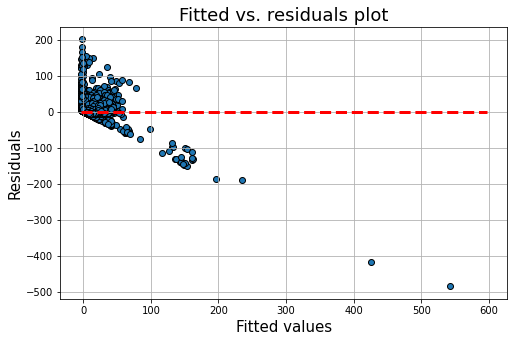

In [73]:
plt.figure(figsize=(8,5))
p=plt.scatter(x=fitted.fittedvalues,y=fitted.resid,edgecolor='k')
xmin=min(fitted.fittedvalues)
xmax = max(fitted.fittedvalues)
plt.hlines(y=0,xmin=xmin*0.9,xmax=xmax*1.1,color='red',linestyle='--',lw=3)
plt.xlabel("Fitted values",fontsize=15)
plt.ylabel("Residuals",fontsize=15)
plt.title("Fitted vs. residuals plot",fontsize=18)
plt.grid(True)
plt.show()

### Histogram of normalized residuals

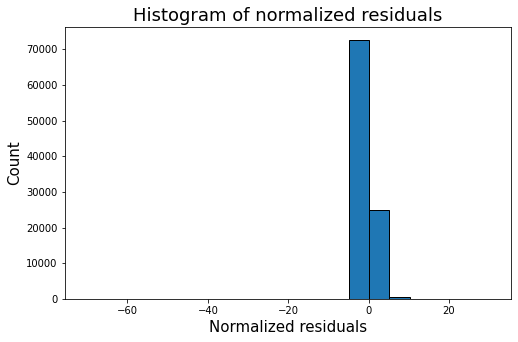

In [55]:
plt.figure(figsize=(8,5))
plt.hist(fitted.resid_pearson,bins=20,edgecolor='k')
plt.ylabel('Count',fontsize=15)
plt.xlabel('Normalized residuals',fontsize=15)
plt.title("Histogram of normalized residuals",fontsize=18)
plt.show()

## QQ Plots of the residuals

In [56]:
from statsmodels.graphics.gofplots import qqplot

<Figure size 576x360 with 0 Axes>

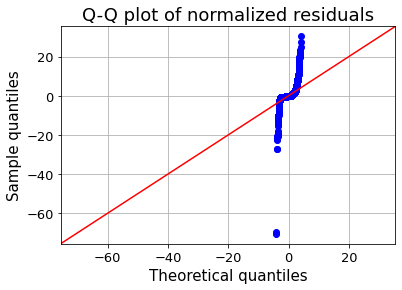

In [57]:
plt.figure(figsize=(8,5))
fig=qqplot(fitted.resid_pearson,line='45',fit='True')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel("Theoretical quantiles",fontsize=15)
plt.ylabel("Sample quantiles",fontsize=15)
plt.title("Q-Q plot of normalized residuals",fontsize=18)
plt.grid(True)
plt.show()

In [58]:
from scipy.stats import shapiro
_,p=shapiro(fitted.resid)


if p<0.01:
    print("The residuals seem to come from Gaussian process")
else:
    print("The normality assumption may not hold")

The residuals seem to come from Gaussian process


/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


### Variance Inflation Factor (VIF)

In [59]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

In [60]:
for i in range(len(data.columns[1:])):
    v=vif(np.matrix(data[1:]),i)
    print("Variance inflation factor for {}: {}".format(df.columns[i],round(v,2)))

Variance inflation factor for fare_amount: 4.9
Variance inflation factor for pickup_longitude: 2.66
Variance inflation factor for pickup_latitude: 14.5
Variance inflation factor for dropoff_longitude: 4.29
Variance inflation factor for dropoff_latitude: 5.35
Variance inflation factor for passenger_count: 3.46
Variance inflation factor for year: 2.64
Variance inflation factor for month: 2.52
